<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#목적" data-toc-modified-id="목적-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>목적</a></span></li><li><span><a href="#데이터-추출" data-toc-modified-id="데이터-추출-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>데이터 추출</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#테스트셋-생성" data-toc-modified-id="테스트셋-생성-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>테스트셋 생성</a></span><ul class="toc-item"><li><span><a href="#계층적-샘플링" data-toc-modified-id="계층적-샘플링-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>계층적 샘플링</a></span></li></ul></li></ul></div>

In [114]:
# libraries

# 데이터 추출
import os
import tarfile
from six.moves import urllib

# 데이터 로드
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams['figure.figsize'] = [12, 5]  # 플롯 기본 크기 설정

# 테스트셋 생성
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

## 목적
* 중간 주택 가격(median housing price) 예측
* 평가 지표: RMSE
* references: https://github.com/rickiepark/handson-ml

## 데이터 추출

In [22]:
# root, url 설정
download_root = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'  # 다운로드 페이지
housing_path = os.path.join('data')  # 저장경로
housing_url = download_root + 'datasets/housing/housing.tgz'


# 데이터 다운로드
def fetch_housing_data(housing_url=housing_url, housing_path=housing_path):
    if not os.path.isdir(housing_path):
        os.mkdir(housing_path)
        
    tgz_path = os.path.join(housing_path, ' housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)  # tgz_path에 저장
    housing_tgz = tarfile.open(tgz_path)  # tgz 파일 열기
    housing_tgz.extractall(path=housing_path)  # tgz 압축을 풀고, housing path에 저장
    housing_tgz.close()
    return f'downloaded data at {housing_path}/, from {housing_url}'

In [23]:
fetch_housing_data()

'downloaded data at data/, from https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz'

## EDA

In [43]:
csv_path = os.path.join(housing_path, 'housing.csv')
housing_df = pd.read_csv(csv_path)

print('='*40 + 'head' + '='* 40)
display(housing_df.head())
print('='*40 + 'info' + '='* 40)
display(housing_df.info())
print(f'shape: {housing_df.shape}')
print('='*40 + 'desc' + '='* 40)
display(housing_df.describe(include='all'))

========================================head========================================


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


========================================info========================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

shape: (20640, 10)
========================================desc========================================


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


* Observations
    * 데이터는 20640행 10열
    * `total_bedrooms` 결측치 207건
    * `ocean_proximity`를 제외한 모든 변수는 수치형

In [35]:
# ocean_proximity 확인
housing_df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

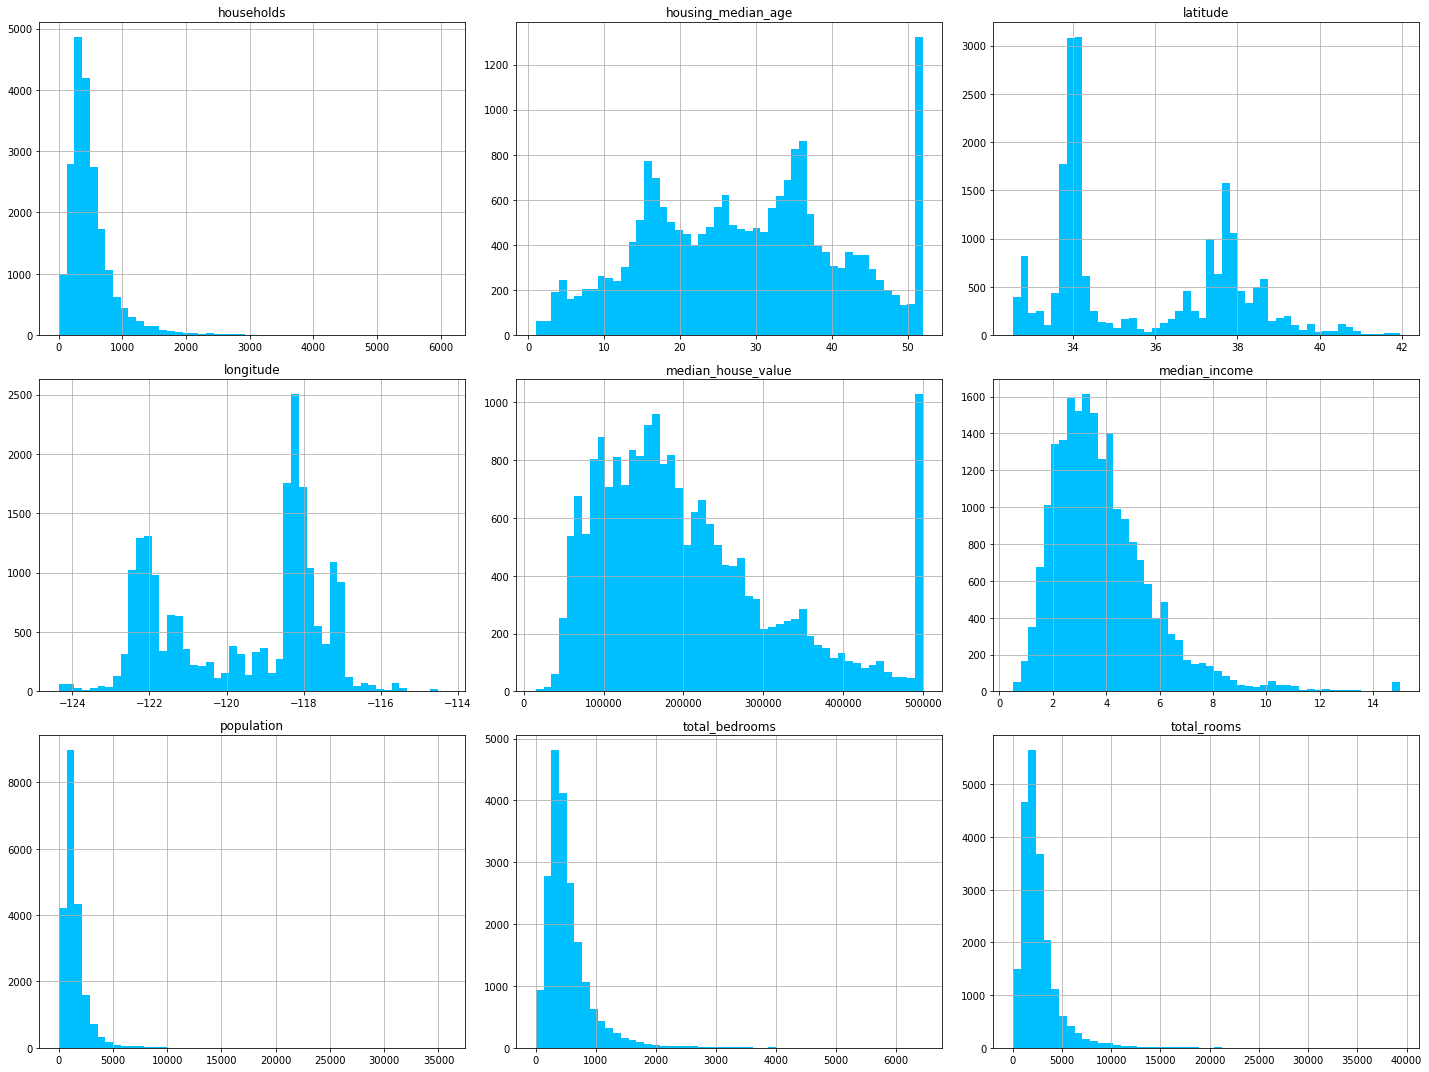

In [59]:
# FAST EDA
housing_df.hist(bins=50, figsize=[20, 15], color='deepskyblue')
plt.tight_layout()
plt.show()

* Observations
    * `중위주택연령(housing_median_age)`, `중위주택가격(housing_median_value)` 히스토그램 우측 값이 가장 높다.
        * 중위주택연령과 중위주택가격의 상한선(50년, 500,000$)을 설정하고, 상한선 이상의 데이터를 모두 상한값으로 처리한것같다.
        * 예측모델이 결과에 상한값이 적용될 수 있다. 
        * 상한값 이상의 결과를 출력하는 예측모델을 만들고 싶다면 
            * 상한값 이상 구역의 데이터를 구해야한다.
            * test data set에서 상한값 이상의 데이터를 제거한다. 만약 상한값 이상의 데이터가 있다면 평가 결과가 나쁠것이다.
    * `중위소득(median_income)`은 스케일링 처리가 된 것으로 보임(0-15)
    * 특성의 범위가 서로 다르다.
        * 스케일링이 필요하다.
    * `household`, `median_income`, `population`, `total_bedrooms`, `total_rooms` 히스토그램은 **양의 왜도**를 보인다.

## 테스트셋 생성
* 데이터 스누핑(data snooping): 테스트셋을 미리 분리하지 않고 데이터를 탐색한 후 테스트 셋의 특성을 예측모델에 적용해 과적합이 발생하는 현상. 데이터를 탐색하기 전에 미리 테스트셋을 분리하는 것이 좋다. 답지를 보면서 문제 푸는것과 비슷하다.

In [61]:
# 1. 트레인 데이터와 테스트 데이터를 8:2로 분류한다.
def split_train_test(data, test_ratio, seed):
    np.random.seed(seed)  # set random seed
    
    indices = np.random.permutation(len(data))  # 인덱스를 섞는다
    test_size = int(len(data) * test_ratio)
    test_indices = suffled_indices[:test_size]
    train_indices = suffled_indices[test_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [82]:
# 2. 해시값으로 테스트셋 생성
def test_set_check(identifier, ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < ratio * 2**32


def split_train_test_by_id(data, ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id_df = housing_df.reset_index()
train_df, test_df = split_train_test_by_id(data=housing_with_id_df, ratio=0.2, id_column='index')

# 위도, 경도와 id를 조합해 고유 식별자 생성
housing_with_id_df['id'] = housing_df['longitude'] * 1000 + housing_df['latitude']
train_df, test_df = split_train_test_by_id(data=housing_with_id_df, ratio=0.2, id_column='id')

In [127]:
# 3. sklearn 모듈 사용
train_df, test_df = train_test_split(housing_df, test_size=0.5, random_state=42)

### 계층적 샘플링
    * 중위소득은 중위주택가격을 예측하는데 중요한 변수다.
    * 테스트셋이 모집단의 중위소득을 반영할 수 있도록 계층적 샘플링을 진행한다.

In [111]:
housing_df['income_cat'] = np.ceil(housing_df['median_income']/1.5)
housing_df['income_cat'].where(cond=housing_df['income_cat']<5.0, other=5, inplace=True)

In [120]:
split = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42)  # 5번 뽑아보자

In [128]:
# y 비율에 따라 계층적 샘플링 진행
# The target variable for supervised learning problems. Stratification is done based on the y labels.
for train_idx, test_idx in split.split(X=housing_df, y=housing_df['income_cat']):
    train_strat_df = housing_df.loc[train_idx]
    test_strat_df = housing_df.loc[test_idx]

In [129]:
# income_cat 비율확인
tot_income_cat_ratio = housing_df['income_cat'].value_counts()/len(housing_df)
test_income_cat_ratio = test_df['income_cat'].value_counts()/len(test_df)
test_strat_income_cat_ratio = test_strat_df['income_cat'].value_counts()/len(test_strat_df)

In [149]:
res_ratio_df = pd.concat([tot_income_cat_ratio, test_income_cat_ratio, test_strat_income_cat_ratio],axis=1)
res_ratio_df.columns=['total', 'random_sample', 'stratified_sample']
res_ratio_df['tot-random'] = res_ratio_df['total'] - res_ratio_df['random_sample']
res_ratio_df['tot-stratified'] = res_ratio_df['total'] - res_ratio_df['stratified_sample']
display(res_ratio_df)

,total,random_sample,stratified_sample,tot-random,tot-stratified
3.0,0.350581,0.355039,0.350533,-0.004457,0.000048
2.0,0.318847,0.319380,0.318798,-0.000533,0.000048
4.0,0.176308,0.173353,0.176357,0.002955,-0.000048
5.0,0.114438,0.113566,0.114583,0.000872,-0.000145
1.0,0.039826,0.038663,0.039729,0.001163,0.000097


In [151]:
# income_cat을 삭제한다.
for set_ in (train_strat_df, test_strat_df):
    set_.drop(['income_cat'], axis=1, inplace=True)